Python Imports

In [36]:
!pip install fredapi
!pip install python-dotenv
import yfinance as yf
import pandas as pd
import numpy as np
from fredapi import Fred
from dotenv import load_dotenv
import os
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

Data Collection

In [46]:
# Downloading Gold Data from Yahoo Finance
ticker = "GC=F"
gold_data = yf.download(ticker, start="2000-09-01")[['Open', 'Close', 'Volume']]

# Fill in non-trading days data with forward fill
gold_data = gold_data.asfreq('D').ffill()

# Feature Engineering - Moving Average 5 days, 100 days, Volitilaty
gold_data.columns = ['Gold_Open', 'Gold_Close', 'Gold_Volume']
gold_data['Gold_Close_MA_5'] = gold_data['Gold_Close'].rolling(window=5).mean()
gold_data.loc[:, 'Gold_Close_MA_5'] = gold_data['Gold_Close_MA_5'].fillna(gold_data['Gold_Close'].iloc[0])

gold_data['Gold_Close_MA_100'] = gold_data['Gold_Close'].rolling(window=100).mean()
gold_data.loc[:, 'Gold_Close_MA_100'] = gold_data['Gold_Close_MA_100'].fillna(gold_data['Gold_Close'].iloc[0])

gold_data['Gold_Close_Volatility'] = gold_data['Gold_Close'].rolling(window=5).std()
gold_data['Gold_Close_Volatility'] = gold_data['Gold_Close_Volatility'].bfill()

# Adding Price Change Features
gold_data['Gold_Close_Change'] = gold_data['Gold_Close'].diff()
gold_data = gold_data.dropna(subset=['Gold_Close_Change'])

gold_data['Price_Change'] = gold_data['Gold_Close_Change']
gold_data['Gain'] = gold_data['Price_Change'].apply(lambda x: x if x > 0 else 0)
gold_data['Loss'] = gold_data['Price_Change'].apply(lambda x: -x if x < 0 else 0)

# RSI Calculation
gold_data['Avg_Gain'] = gold_data['Gain'].rolling(window=14).mean()
gold_data['Avg_Loss'] = gold_data['Loss'].rolling(window=14).mean()
gold_data['RS'] = gold_data['Avg_Gain'] / gold_data['Avg_Loss']
gold_data['RSI'] = 100 - (100 / (1 + gold_data['RS']))
gold_data['RSI'] = gold_data['RSI'].bfill()

# MACD Calculation
gold_data['EMA_12'] = gold_data['Gold_Close'].ewm(span=12, adjust=False).mean()
gold_data['EMA_26'] = gold_data['Gold_Close'].ewm(span=26, adjust=False).mean()
gold_data['MACD'] = gold_data['EMA_12'] - gold_data['EMA_26']
gold_data['Signal_Line'] = gold_data['MACD'].ewm(span=9, adjust=False).mean()
gold_data['MACD_Histogram'] = gold_data['MACD'] - gold_data['Signal_Line']

[*********************100%***********************]  1 of 1 completed


In [38]:
# Downloading FRED Data for GDP, interest rate, unemployment, USD-Franc Exchange Rate
# Load environment variables
load_dotenv()
FRED_API_Key = os.getenv("FRED_API")

# Initialize FRED API
fred = Fred(api_key=FRED_API_Key)

# Fetch economic indicators
gdp = fred.get_series('GDP')
interest_rate = fred.get_series('FEDFUNDS')
unemployment = fred.get_series('UNRATE')
usd_franc = fred.get_series('DEXSZUS')

# Convert to DataFrames
gdp = gdp.to_frame(name='GDP')
interest_rate = interest_rate.to_frame(name='Interest_Rate')
unemployment = unemployment.to_frame(name='Unemployment')
usd_franc = usd_franc.to_frame(name='USD_FRANC')

# Merge all dataframes
economic_data = gdp.join([interest_rate, unemployment, usd_franc], how='outer')

# Reindex to daily frequency and forward fill missing values
economic_data = economic_data.asfreq('D').ffill()

# Cut data at September 1, 2000
economic_data = economic_data.loc['2000-09-01':]

# Log transform GDP
economic_data['Log_GDP'] = np.log(economic_data['GDP'])
economic_data.index = pd.to_datetime(economic_data.index)

In [39]:
# Download S&P 500 data from Yahoo Finance
sp500_data = yf.download("^GSPC", start="2000-09-01")[['Close']]
sp500_data.columns = ['SP500_Close']

# Fill in non-trading days data with forward fill
sp500_data = sp500_data.asfreq('D').ffill()

# Merge S&P 500 data with existing economic data
economic_data = economic_data.join(sp500_data, how='outer')

# Forward-fill any missing values
economic_data = economic_data.ffill()

[*********************100%***********************]  1 of 1 completed


In [40]:
# Merge economic data with gold data on date
final_data = economic_data.join(gold_data, how='outer')

# Limit data up to last quarter data from FRED
final_data = final_data.loc[:'2025-03-21']

# Forward-fill any missing values
final_data = final_data.bfill()

# Display the first few rows
print(final_data)

final_data.to_csv('final_gold_and_economic_data.csv')

                  GDP  Interest_Rate  Unemployment  USD_FRANC    Log_GDP  \
2000-09-01  10318.165           6.52           3.9     1.7230   9.241661   
2000-09-02  10318.165           6.52           3.9     1.7230   9.241661   
2000-09-03  10318.165           6.52           3.9     1.7230   9.241661   
2000-09-04  10318.165           6.52           3.9     1.7230   9.241661   
2000-09-05  10318.165           6.52           3.9     1.7488   9.241661   
...               ...            ...           ...        ...        ...   
2025-03-17  29723.864           4.33           4.1     0.8812  10.299706   
2025-03-18  29723.864           4.33           4.1     0.8773  10.299706   
2025-03-19  29723.864           4.33           4.1     0.8800  10.299706   
2025-03-20  29723.864           4.33           4.1     0.8826  10.299706   
2025-03-21  29723.864           4.33           4.1     0.8834  10.299706   

            SP500_Close    Gold_Open   Gold_Close  Gold_Volume  \
2000-09-01  1520.7700

Ridge Regression with K-Fold Cross-Validation:
Average Training R²: 0.9998
Average Test R²: 0.9983
Average Training MSE: 51.6950
Average Test MSE: 53.4709

Coefficients of Ridge Regression (for the last fold):
                       Coefficient
Interest_Rate             0.510378
Unemployment              0.858407
USD_FRANC                -0.650862
SP500_Close               1.256518
Gold_Volume              -0.110560
Gold_Close_Change         8.157791
Gold_Close_MA_5         589.225158
Gold_Close_MA_100         8.489207
Gold_Close_Volatility    -0.082912
RSI                       0.596811
MACD_Histogram            4.162230


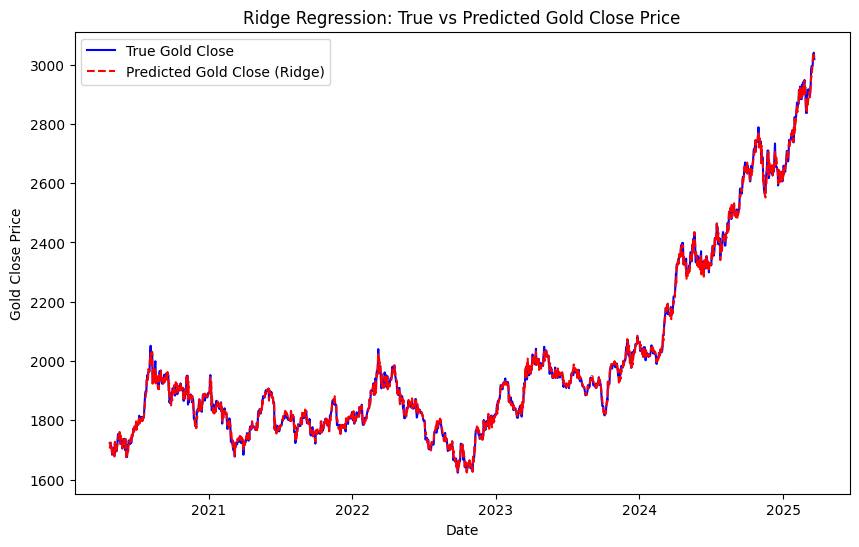

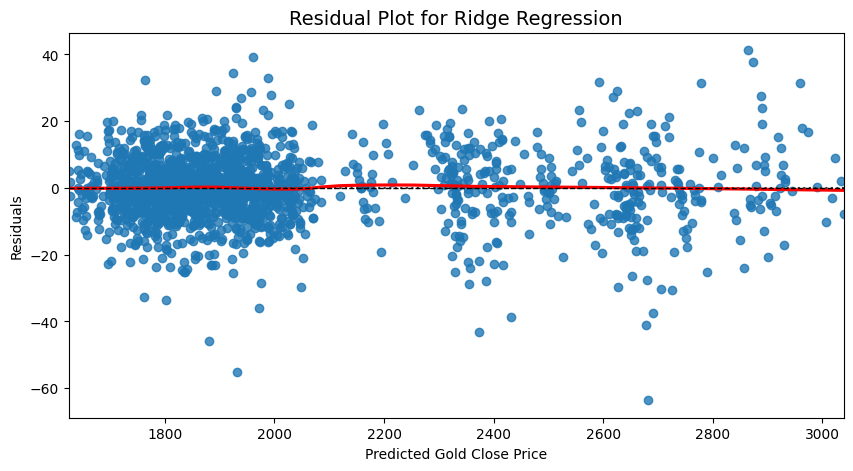

                            OLS Regression Results                            
Dep. Variable:             Gold_Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.802e+06
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:47:42   Log-Likelihood:                -30307.
No. Observations:                8968   AIC:                         6.064e+04
Df Residuals:                    8956   BIC:                         6.072e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.22

In [41]:
# Features and target variable
features = final_data[['Interest_Rate', 'Unemployment',
                       'USD_FRANC', 'SP500_Close', 'Gold_Volume', 'Gold_Close_Change', 'Gold_Close_MA_5','Gold_Close_MA_100', 'Gold_Close_Volatility', 'RSI', 'MACD_Histogram']]
target = final_data['Gold_Close']

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Initialize the Ridge Regression model
ridge_model = Ridge(alpha=1)

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=False)

# Store results for each fold
train_r2_scores = []
test_r2_scores = []
train_mse_scores = []
test_mse_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(features_scaled):
    X_train, X_test = features_scaled[train_index], features_scaled[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    # Fit the model
    ridge_model.fit(X_train, y_train)

    # Predict on training and test data
    y_train_pred = ridge_model.predict(X_train)
    y_test_pred = ridge_model.predict(X_test)

    # Calculate performance metrics for the fold
    train_r2_scores.append(r2_score(y_train, y_train_pred))
    test_r2_scores.append(r2_score(y_test, y_test_pred))
    train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
    test_mse_scores.append(mean_squared_error(y_test, y_test_pred))

# Calculate the average metrics across all folds
avg_train_r2 = sum(train_r2_scores) / len(train_r2_scores)
avg_test_r2 = sum(test_r2_scores) / len(test_r2_scores)
avg_train_mse = sum(train_mse_scores) / len(train_mse_scores)
avg_test_mse = sum(test_mse_scores) / len(test_mse_scores)

# Print out the results
print("Ridge Regression with K-Fold Cross-Validation:")
print(f"Average Training R²: {avg_train_r2:.4f}")
print(f"Average Test R²: {avg_test_r2:.4f}")
print(f"Average Training MSE: {avg_train_mse:.4f}")
print(f"Average Test MSE: {avg_test_mse:.4f}")

# Display coefficients for last fold
coefficients = pd.DataFrame(ridge_model.coef_, features.columns, columns=['Coefficient'])
print("\nCoefficients of Ridge Regression (for the last fold):")
print(coefficients)

# Plot the predictions for the last fold
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='True Gold Close', color='blue')
plt.plot(y_test.index, y_test_pred, label='Predicted Gold Close (Ridge)', color='red', linestyle='dashed')
plt.title('Ridge Regression: True vs Predicted Gold Close Price')
plt.xlabel('Date')
plt.ylabel('Gold Close Price')
plt.legend()
plt.show()

# Create residuals for the last fold
residuals = y_test - y_test_pred

# Residual Plot
plt.figure(figsize=(10, 5))
sns.residplot(x=y_test_pred, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.title("Residual Plot for Ridge Regression", fontsize=14)
plt.xlabel("Predicted Gold Close Price")
plt.ylabel("Residuals")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()

# Add a constant (intercept) to the features for OLS regression
X = sm.add_constant(features)  # Add constant (intercept) to the model
y = target

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Get the summary of the model, which includes the p-values for each feature
print(ols_model.summary())



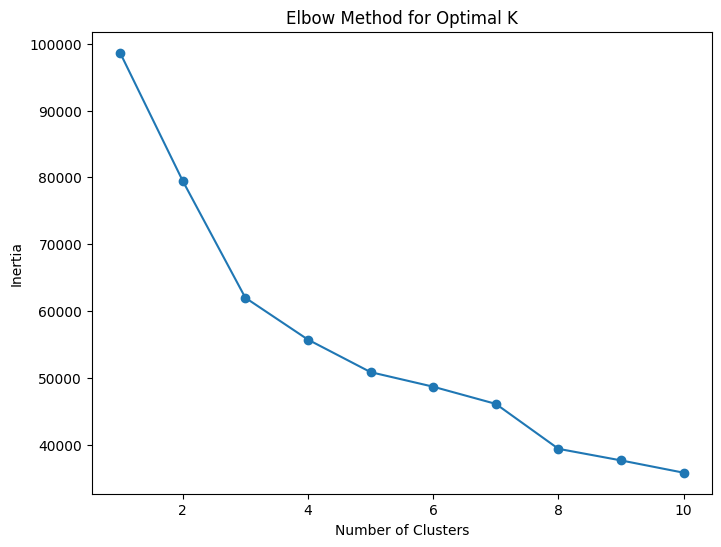

In [47]:
# Select relevant features for clustering
features = final_data[['Interest_Rate', 'Unemployment',
                       'USD_FRANC', 'SP500_Close', 'Gold_Volume', 'Gold_Close_Change', 'Gold_Close_MA_5','Gold_Close_MA_100', 'Gold_Close_Volatility', 'RSI', 'MACD_Histogram']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Elbow method to find optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot inertia to identify the elbow point
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
final_data['Cluster'] = kmeans.fit_predict(features_scaled)

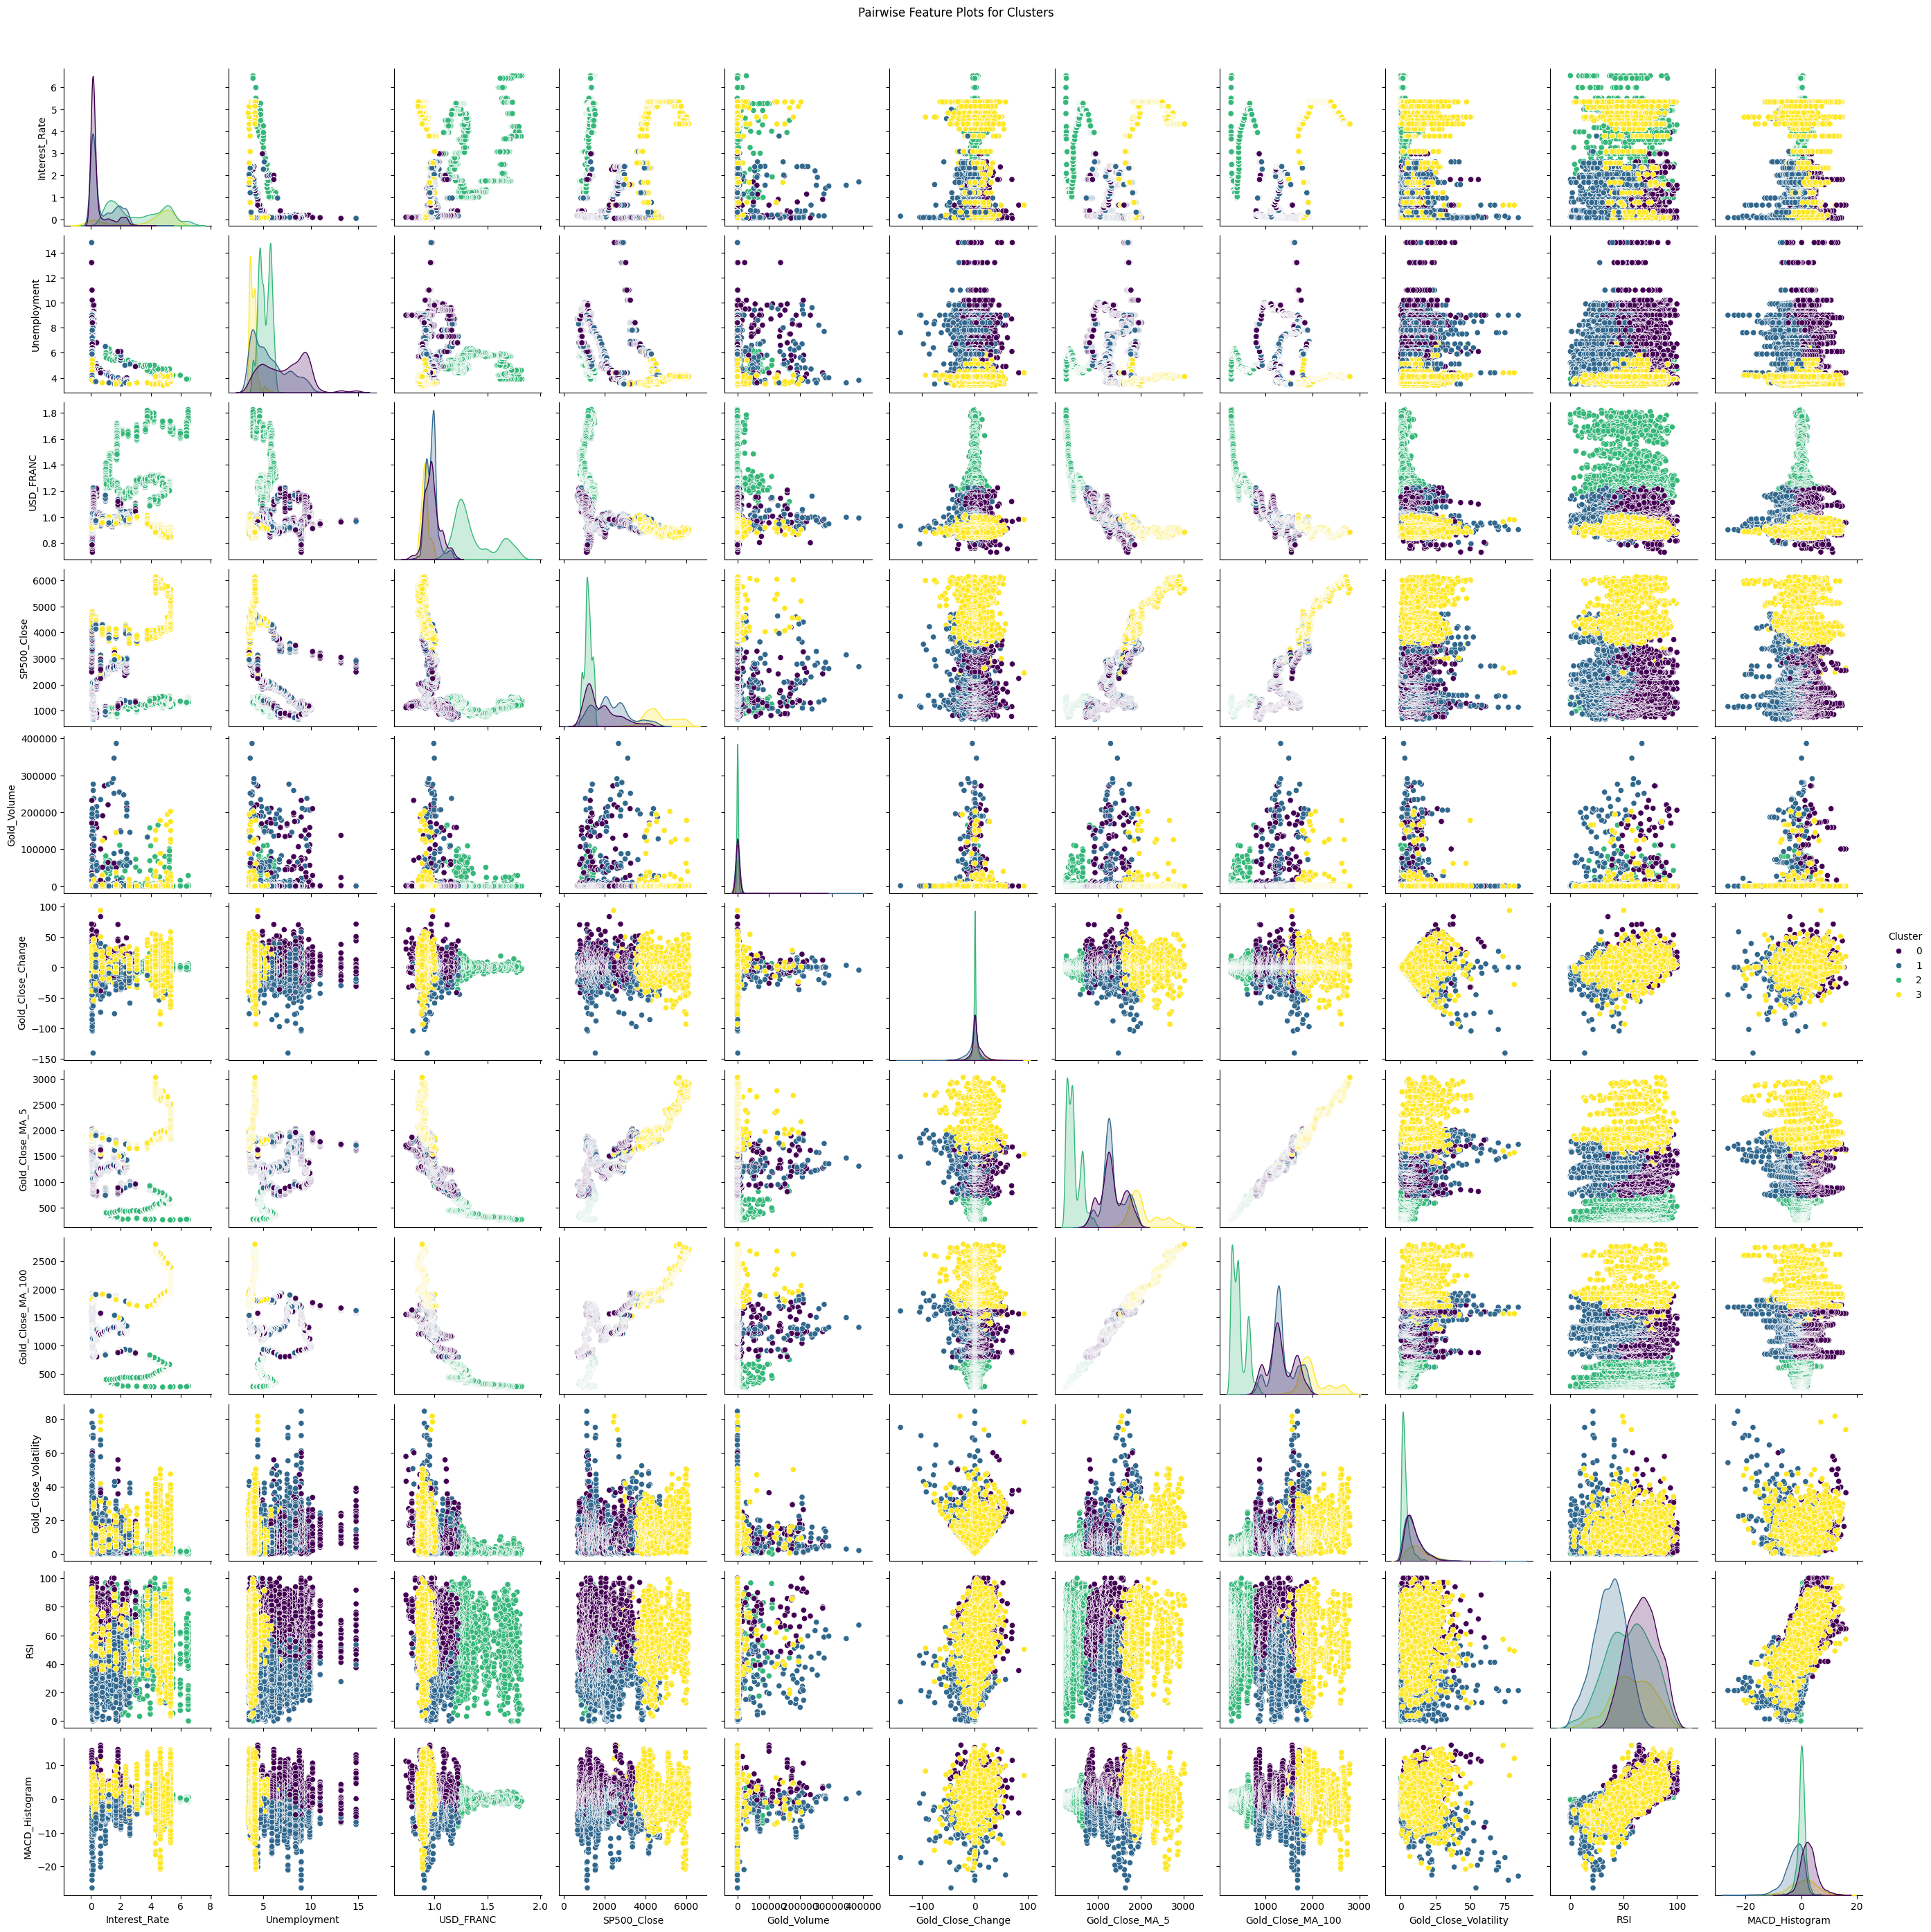

In [44]:
# Visualizing all pairs of features with the clusters
sns.pairplot(final_data[['Interest_Rate', 'Unemployment', 'USD_FRANC', 'SP500_Close', 'Gold_Volume',
                          'Gold_Close_Change', 'Gold_Close_MA_5', 'Gold_Close_MA_100', 'Gold_Close_Volatility',
                          'RSI', 'MACD_Histogram', 'Cluster']], hue='Cluster', palette='viridis', diag_kind='kde', markers='o')

plt.suptitle('Pairwise Feature Plots for Clusters', y=1.02)
plt.show()

In [45]:
# Group by 'Cluster' and calculate the mean of each feature
cluster_means = final_data.groupby('Cluster')[['Interest_Rate', 'Unemployment', 'USD_FRANC', 'SP500_Close', 'Gold_Volume',
                                              'Gold_Close_Change', 'Gold_Close_MA_5', 'Gold_Close_MA_100', 'Gold_Close_Volatility',
                                              'RSI', 'MACD_Histogram']].mean()

# Display the average values for each feature for each cluster
print("Average values for each feature by cluster:")
print(cluster_means)


Average values for each feature by cluster:
         Interest_Rate  Unemployment  USD_FRANC  SP500_Close  Gold_Volume  \
Cluster                                                                     
0             0.428616      7.365935   0.976368  1819.637021  5119.860340   
1             0.779355      5.696641   0.971104  2316.854771  6016.751351   
2             3.189708      5.134392   1.372573  1195.637149  1971.138372   
3             3.751909      3.890131   0.908479  4683.528494  3287.747145   

         Gold_Close_Change  Gold_Close_MA_5  Gold_Close_MA_100  \
Cluster                                                          
0                 3.701451      1343.057680        1319.997406   
1                -3.738649      1358.378703        1365.696626   
2                 0.253742       445.424549         434.957884   
3                 2.281974      2076.558072        2029.938740   

         Gold_Close_Volatility        RSI  MACD_Histogram  
Cluster                             